# Sarsa with eligibility traces

<p align="center">
  <img src="sarsa_elig.png" alt="ny" width="500">
</p>
<br>

In [12]:
from nim_env import NimEnv
from utils import compute_nim_sum, optimal_policy, random_policy
import random
import matplotlib.pyplot as plt
import numpy as np
from sarsa import RLAgent
from sarsa_lambda import SARSA_LAMBDA
from montecarlo import MonteCarlo
from tqdm import tqdm
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format

# plt figure setup
from matplotlib import rc

plt.rc('axes', labelsize=14)   # fontsize of the x and y labels
plt.rc('axes', titlesize=14)
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=14)   # fontsize of the figure title
plt.rc('lines', markersize=7)
plt.rc('lines', linewidth=2)

In [2]:
import random

def evaluate_fixed(agent, N):
    player0_ep_rewards = [0]*N
    player1_ep_rewards = [0]*N
    for i in range(N):
        done = False
        heaps = random.sample(range(1, 8), 3)
        env = NimEnv(heaps)
        turn = 0
        while not done:
            action = agent.decide(heaps)
            next_heaps, winner, reward, done, turn = env.step(action)
            if done:
                break
            adv_action = optimal_policy(next_heaps,  randomness=0.2)
            nextnext_heaps, winner, adv_reward, done, _ = env.step(adv_action)
            heaps = nextnext_heaps


        if winner == 0:
            player0_ep_rewards.append(1)  
            player1_ep_rewards.append(-1) 
        else: # if winner == 1 
            player0_ep_rewards.append(-1)
            player1_ep_rewards.append(1) 

    return np.mean(player0_ep_rewards), np.mean(player1_ep_rewards)

In [3]:
heaps = [7,7,7]
env = NimEnv(heaps)


def run_experiment(env, num_episodes):
    player0_rewards = []
    player1_rewards = []
    agent0 = SARSA_LAMBDA() # RL agent for player 0
    # agent1 = RLAgent() # RL agent for player 1

    for episode in tqdm(range(1, num_episodes+1)):
        heaps = env.reset() 
        env = NimEnv(heaps)
        
        winner = None
        done = False

        action = None
        reward = None
        old_0 = (None, None) # old state/action for player0
        old_reward = None
        i = 0
        agent0.resetE() # reset elig traces to 0
        while not done:
            action = agent0.decide(heaps)
            next_heaps, winner, reward, done, _ = env.step(action)
            if i > 0:
                agent0.learn(old_0[0], old_0[1], old_reward, heaps, action)
            if done:
                agent0.learn(heaps, action, reward[0])
                break
            
            adv_action = optimal_policy(next_heaps,  randomness=0.2)
            nextnext_heaps, winner, adv_reward, done, _ = env.step(adv_action)
            if done:
                agent0.learn(heaps, action, adv_reward[0])
                break
            
            old_0 = heaps, action
            old_reward = adv_reward[0]
            heaps = nextnext_heaps
            i += 1

        r0, r1 = evaluate_fixed(agent0, 10)
        player0_rewards.append(r0)  
        player1_rewards.append(r1) 
                
    return player0_rewards, player1_rewards, agent0

In [6]:
num_episodes = 50000
r0, r1, agent = run_experiment(env, num_episodes)

100%|██████████| 50000/50000 [06:13<00:00, 133.86it/s]


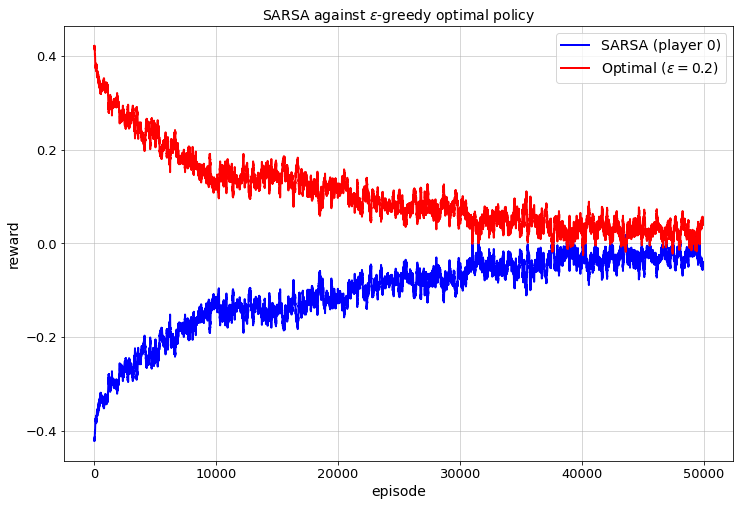

In [8]:
N=100
r0_conv = np.convolve(r0, np.ones(N)/N, mode='valid')
r1_conv = np.convolve(r1, np.ones(N)/N, mode='valid')
fig = plt.figure(figsize=(12,8))
plt.plot(range(1, len(r0_conv)+1), r0_conv, color='b', label='SARSA (player 0)')
plt.plot(range(1, len(r1_conv)+1), r1_conv, color='r', label=r'Optimal ($\epsilon = 0.2$)')
plt.legend()
plt.xlabel('episode')
plt.ylabel('reward')
plt.grid(True,'major',linestyle='-',linewidth=0.5)
plt.grid(True,'minor',linestyle='--',linewidth=0.25) 
plt.title(r'SARSA against $\epsilon$-greedy optimal policy')
plt.show()

In [9]:
import random

def evaluate(agent, N):
    player0_ep_rewards = [0]*N
    player1_ep_rewards = [0]*N
    for i in range(N):
        done = False
        heaps = random.sample(range(1, 8), 3)
        env = NimEnv(heaps)
        turn = 0
        while not done:
            action = agent[turn].decide(heaps)
            next_heaps, winner, reward, done, turn = env.step(action)
        if winner == 0:
            player0_ep_rewards.append(1)  
            player1_ep_rewards.append(-1) 
        else: # if winner == 1 
            player0_ep_rewards.append(-1)
            player1_ep_rewards.append(1) 

    return np.mean(player0_ep_rewards), np.mean(player1_ep_rewards)

In [15]:
heaps = [7,7,7]
env = NimEnv(heaps)


def run_experiment(env, num_episodes):
    player0_rewards = []
    player1_rewards = []
    agent0 = RLAgent() # RL agent for player 0
    agent1 = SARSA_LAMBDA() # RL agent for player 1

    for episode in tqdm(range(1, num_episodes+1)):
        heaps = env.reset() 
        env = NimEnv(heaps)
        
        winner = None
        done = False

        action = [None, None]
        reward = [None, None]
        old_0 = (None, None) # old state/action for player0
        old_1 = (None, None) # old state/action for player1
        old_reward = None
        i = 0
        agent1.resetE()
        while not done:
            action[0] = agent0.decide(heaps)
            next_heaps, winner, reward[0], done, _ = env.step(action[0])
            if i > 0:
                agent0.learn(old_0[0], old_0[1], old_reward[0], heaps, action[0])
            if done:
                agent0.learn(heaps, action[0], reward[0][0])
                if i > 0:
                    agent1.learn(old_1[0], old_1[1], reward[0][1])
                break
            
            action[1] = agent1.decide(next_heaps)
            nextnext_heaps, winner, reward[1], done, _ = env.step(action[1])
            if i > 0:
                agent1.learn(old_1[0], old_1[1], old_reward[1], next_heaps, action[1])
            if done:
                agent0.learn(heaps, action[0], reward[1][0])
                agent1.learn(next_heaps, action[1], reward[1][1])
                break
            

            old_0 = heaps, action[0]
            old_1 = next_heaps, action[1]
            old_reward = reward[1]
            heaps = nextnext_heaps
            i += 1

        r0, r1 = evaluate([agent0, agent1], 10)
        player0_rewards.append(r0)  
        player1_rewards.append(r1) 
                
    return player0_rewards, player1_rewards, [agent0, agent1]


In [19]:
num_episodes = 100_000
r0, r1, agents = run_experiment(env, num_episodes)

100%|██████████| 100000/100000 [18:29<00:00, 90.12it/s]


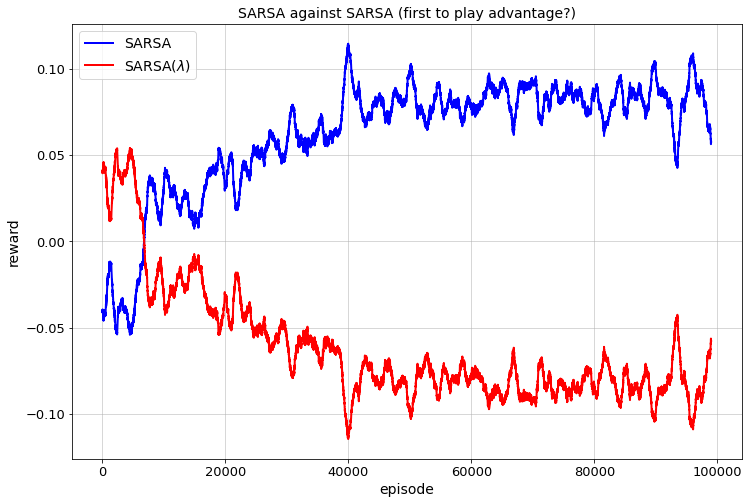

In [21]:
N=1000
r0_conv = np.convolve(r0, np.ones(N)/N, mode='valid')
r1_conv = np.convolve(r1, np.ones(N)/N, mode='valid')
fig = plt.figure(figsize=(12,8))
plt.plot(range(1, len(r0_conv)+1), r0_conv, color='b', label='SARSA')
plt.plot(range(1, len(r1_conv)+1), r1_conv, color='r', label=r'SARSA($\lambda$)')
plt.legend()
plt.xlabel('episode')
plt.ylabel('reward')
plt.grid(True,'major',linestyle='-',linewidth=0.5)
plt.grid(True,'minor',linestyle='--',linewidth=0.25) 
plt.title(r'SARSA against SARSA (first to play advantage?)')
plt.show()